# 0. Import thư viện

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# 1. Data preprocessing

In [2]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="0zQUDwd0LCNQbBNvcADD")
project = rf.workspace("test-rgyee").project("yolo-ocr")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to yolo-ocr-2 in yolov8:: 100%|██████████| 4476/4476 [00:01<00:00, 2506.19it/s]


In [4]:
image_train_paths = "/content/yolo-ocr-2/train/images/"
label_train_paths = "/content/yolo-ocr-2/train/labels/"
image_test_paths = "/content/yolo-ocr-2/test/images/"
label_test_paths = "/content/yolo-ocr-2/test/labels/"

In [5]:
list_image_train = sorted(os.listdir(image_train_paths))
list_label_train = sorted(os.listdir(label_train_paths))
list_image_test = sorted(os.listdir(image_test_paths))
list_label_test = sorted(os.listdir(label_test_paths))

In [6]:
print("Số lượng ảnh train: ", len(list_image_train))
print("Số lượng ảnh test: ", len(list_image_test))

Số lượng ảnh train:  1565
Số lượng ảnh test:  222


**Ảnh mẫu**

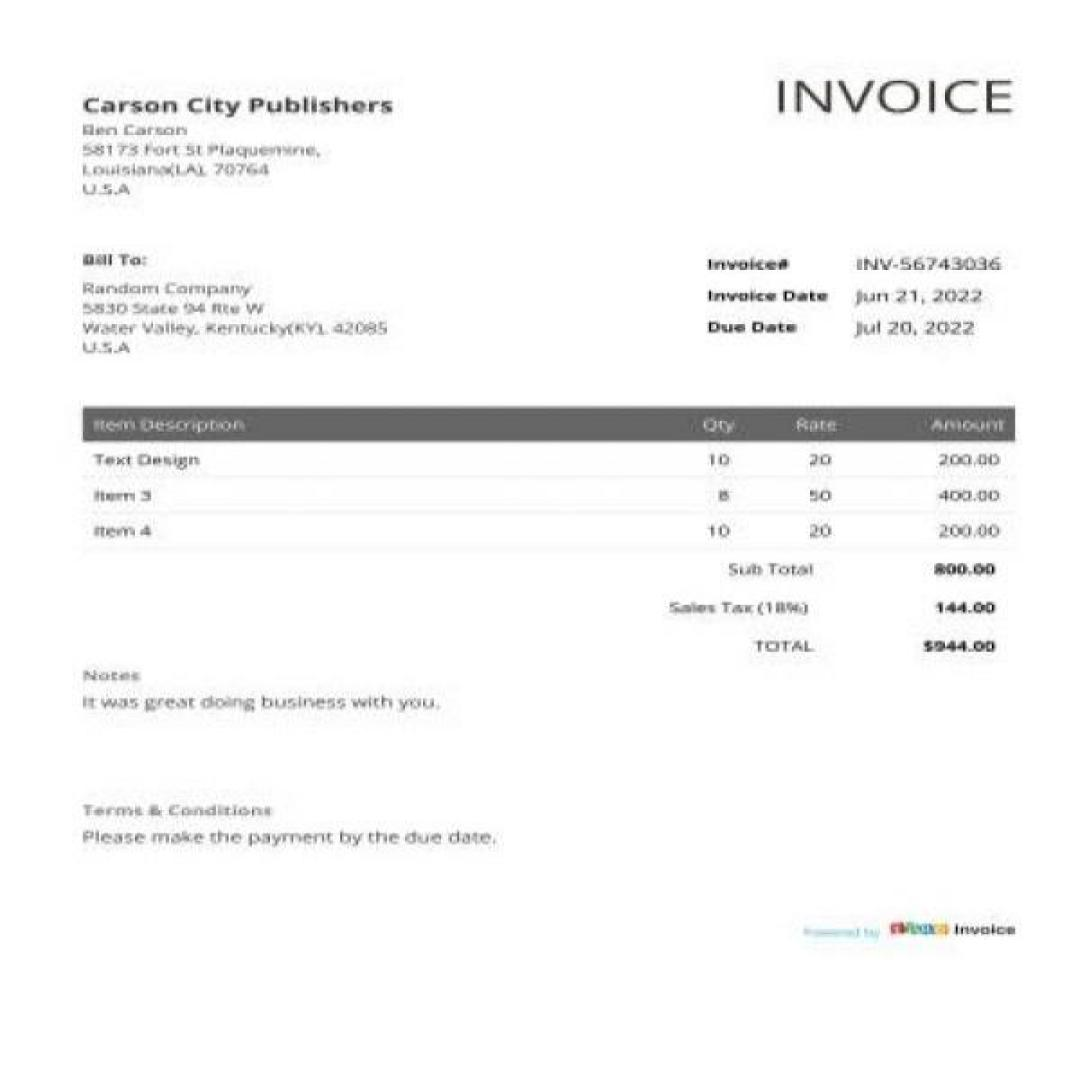

In [7]:
random_index = np.random.randint(0, len(list_image_train))
image_train = list_image_train[random_index]
label_train = list_label_train[random_index]
img = Image.open(os.path.join(image_train_paths, image_train))
img

In [8]:
path = os.path.join(label_train_paths, label_train)
with open(path, 'r') as f:
  lines = f.readlines()

In [9]:
def denormalize_labels(labels, image_width, image_height):
    denormalized_labels = []
    for label in labels:
        cls, x_center, y_center, width, height = map(float, label.split())
        x_center = x_center * image_width
        y_center = y_center * image_height
        width = width * image_width
        height = height * image_height

        x_min = int(x_center - (width / 2))
        y_min = int(y_center - (height / 2))
        x_max = int(x_center + (width / 2))
        y_max = int(y_center + (height / 2))

        denormalized_labels.append([int(cls), x_min, y_min, x_max, y_max])

    return denormalized_labels

In [10]:
img = cv2.imread(os.path.join(image_train_paths, image_train))

In [11]:
label = denormalize_labels(lines, img.shape[1], img.shape[0])

In [12]:
label

[[2, 66, 229, 405, 368],
 [6, 846, 241, 1011, 282],
 [5, 847, 280, 995, 310],
 [8, 75, 388, 1018, 668],
 [9, 916, 631, 1002, 661]]

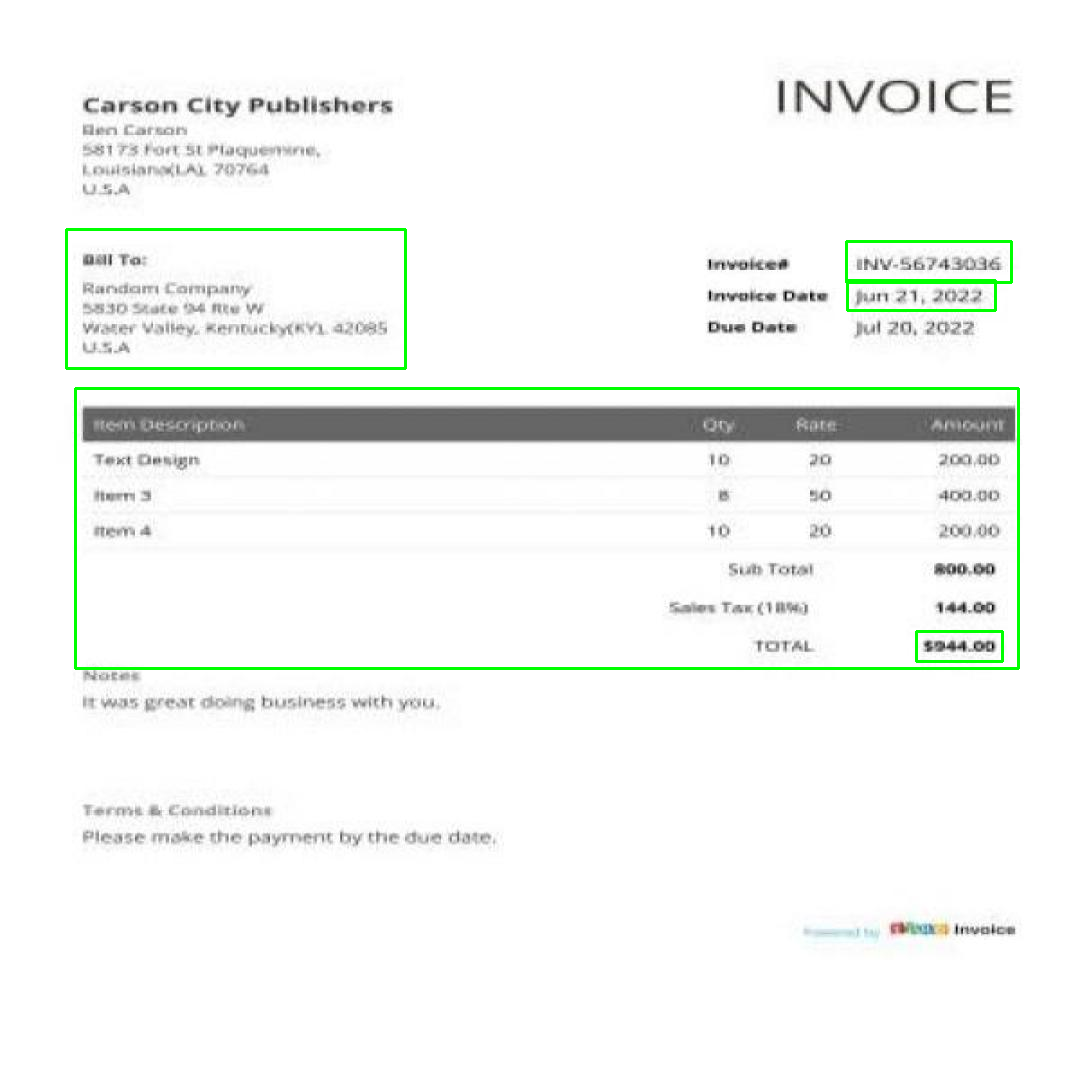

In [13]:
from google.colab.patches import cv2_imshow
for item in label:
  cv2.rectangle(img, (item[1], item[2]), (item[3], item[4]), (0, 255, 0), 2)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 2. Text Detection

In [14]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.7/802.7 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [15]:
from ultralytics import YOLO

In [18]:
# # Trước khi train thì nên dùng shutil để đưa chuyển thành thư mục này(lý do thì tôi chưa tìm ra)
# import shutil

# shutil.move('/content/yolo-ocr-2/train',
#             '/content/yolo-ocr-2/yolo-ocr-2/train'
#             )

# shutil.move('/content/yolo-ocr-2/test',
#             '/content/yolo-ocr-2/yolo-ocr-2/test'
#             )

# shutil.move('/content/yolo-ocr-2/valid',
#             '/content/yolo-ocr-2/yolo-ocr-2/valid'
#             )

'/content/yolo-ocr-2/yolo-ocr-2/valid'

In [20]:
# # Train
# !yolo task=detect mode=train model='/content/drive/MyDrive/OCR_Bill/best.pt' data={dataset.location}/data.yaml epochs=10 imgsz=640

Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/OCR_Bill/best.pt, data=/content/yolo-ocr-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

In [31]:
model = YOLO('/content/drive/MyDrive/OCR_Bill/best.pt')

In [32]:
result = model.predict(img)


0: 640x640 1 OMRON_address, 1 bill_to, 1 company_chop, 2 dates, 1 table, 4725.8ms
Speed: 9.4ms preprocess, 4725.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


In [33]:
result

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'OMRON_address', 1: 'OMRON_name', 2: 'bill_to', 3: 'company_chop', 4: 'currency', 5: 'date', 6: 'invoice_no', 7: 'ship_to', 8: 'table', 9: 'total_amount'}
 obb: None
 orig_img: array([[[233, 233, 233],
         [236, 236, 236],
         [240, 240, 240],
         ...,
         [237, 237, 237],
         [215, 215, 215],
         [191, 191, 191]],
 
        [[237, 237, 237],
         [241, 241, 241],
         [245, 245, 245],
         ...,
         [241, 241, 241],
         [219, 219, 219],
         [194, 194, 194]],
 
        [[241, 241, 241],
         [245, 245, 245],
         [250, 250, 250],
         ...,
         [245, 245, 245],
         [222, 222, 222],
         [196, 196, 196]],
 
        ...,
 
        [[240, 240, 240],
         [240, 240, 240],
         [241, 241, 241],
         ...,
         [233, 233, 233],
         [214, 214, 

In [34]:
bbox = result[0].boxes.data
bbox #(x_min, y_min, x_max, y_max, confidence, class)

tensor([[8.1263e+02, 3.3262e+02, 9.6528e+02, 4.8342e+02, 8.6664e-01, 3.0000e+00],
        [3.6289e+01, 4.6085e+02, 1.0506e+03, 6.2332e+02, 7.9945e-01, 8.0000e+00],
        [9.9858e+01, 2.0961e+02, 4.4067e+02, 2.2764e+02, 6.8703e-01, 0.0000e+00],
        [6.0538e+02, 3.9537e+02, 6.5180e+02, 4.1140e+02, 5.6207e-01, 5.0000e+00],
        [6.2216e+02, 4.4883e+02, 6.6917e+02, 4.5892e+02, 3.2403e-01, 5.0000e+00],
        [9.2713e+01, 2.4938e+02, 4.5097e+02, 2.8293e+02, 3.1085e-01, 2.0000e+00]])

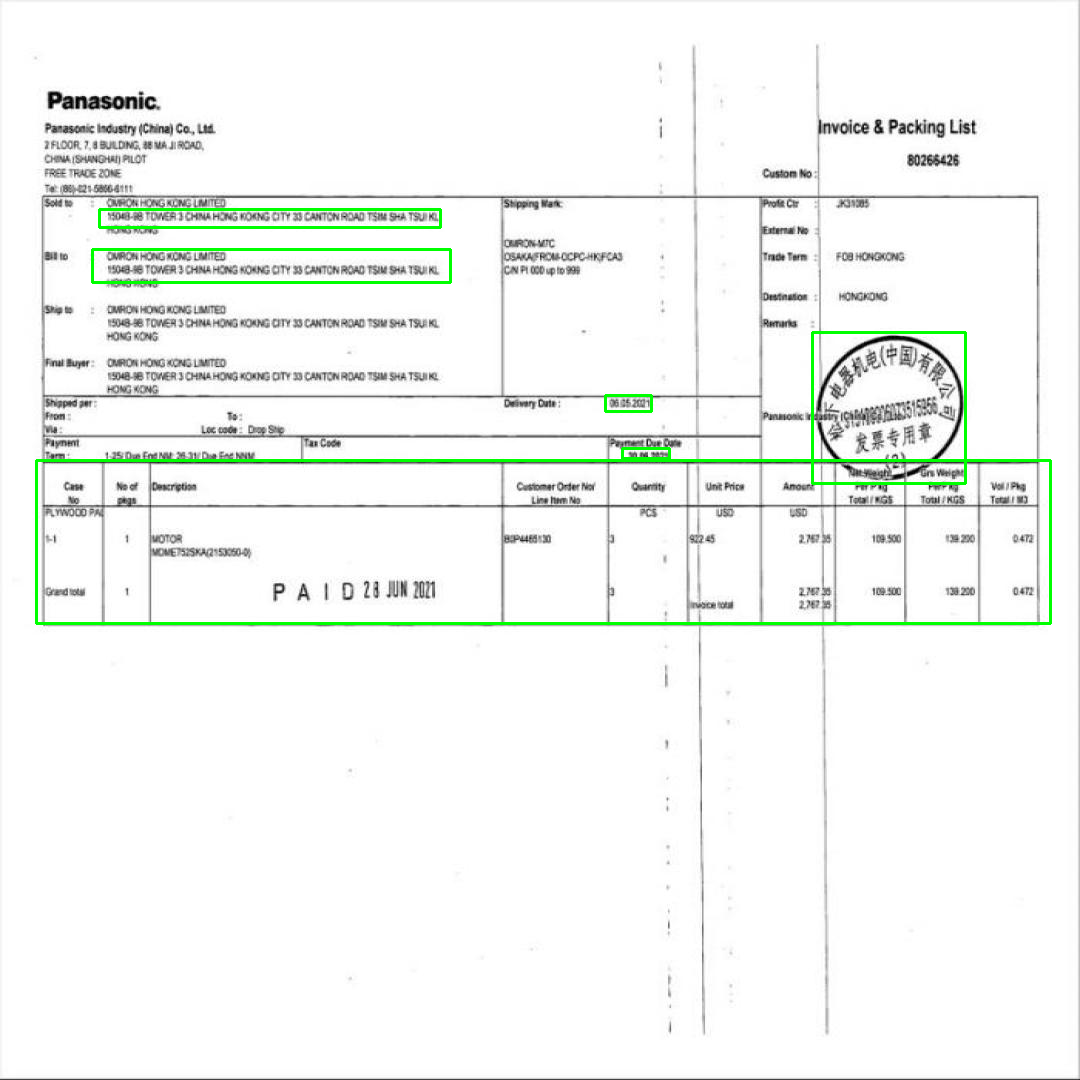

In [35]:
img2 = cv2.imread(os.path.join(image_train_paths, image_train))
for item in bbox:
  x_min, y_min, x_max, y_max, conf, cls = item
  x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
  cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 3. Text Recognition

In [36]:
!pip install --quiet vietocr

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 27.0 MB/s eta 0:00:00


In [37]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [38]:
config = Cfg.load_config_from_name('vgg_transformer')

In [39]:
# config['weights'] = './weights/transformerocr.pth'
# config['cnn']['pretrained']=False
config['device'] = 'cpu'

In [40]:
detector = Predictor(config)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:09<00:00, 58.0MB/s]
enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
18533it [00:09, 1967.25it/s]


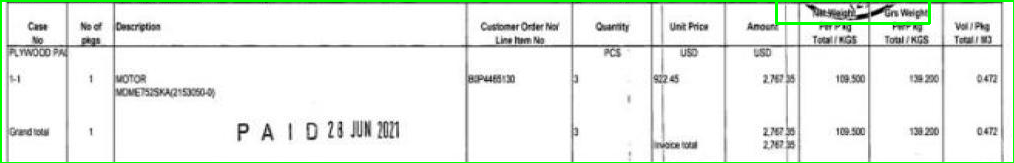

In [41]:
x_min, y_min, x_max, y_max, conf, cls = bbox[1]
x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
bbox_1 = img2[y_min:y_max, x_min:x_max]
cv2_imshow(bbox_1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [42]:
bbox_1_pil = Image.fromarray(bbox_1)
detector.predict(bbox_1_pil)

'TRANSFEETER'

## 3.x Train model

In [ ]:
# from vietocr.model.trainer import Trainer

In [ ]:
# config = Cfg.load_config_from_name('vgg_transformer')

In [ ]:
# trainer = Trainer(config, pretrained=True)

In [ ]:
# trainer.config.save('config.yml') # Lưu lại cấu hình của model

In [ ]:
# trainer.visualize_dataset() # Kiểm tra xem dữ liệu dùng để train hợp lí chưa

In [ ]:
# trainer.train()

In [56]:
img2 = cv2.imread('/content/yolo-ocr-2/test/images/0014_jpg.rf.c4f923fdf27b0158a5e4ac266cc38ec9.jpg')
OCR_bill(img2)


0: 640x640 1 bill_to, 1 date, 1 invoice_no, 1 ship_to, 1 table, 1 total_amount, 5204.1ms
Speed: 8.7ms preprocess, 5204.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


'{\n "table": [\n  "TRANSET"\n ],\n "ship_to": [\n  "Em"\n ],\n "bill_to": [\n  "Destrain"\n ],\n "total_amount": [\n  "sens 17"\n ],\n "invoice_no": [\n  "00088159491"\n ],\n "date": [\n  "Apr 19, 2022"\n ]\n}'